# Прогнозирование цен на жилье - задача регрессии (с применением t-SNE для снижения размерности)

Простой, но сложный проект для прогнозирования цены на жилье на основе определенных факторов, таких как площадь дома, спальни, меблировка, близость к главной дороге и т.д. Набор данных пока небольшой, его сложность возникает из-за того, что он обладает сильной мультиколлинеарностью.  

Оценка стоимости жилья полезна для всех участников рынка недвижимости, включая покупателей, продавцов, инвесторов, риелторов и финансовые учреждения.

## О наборе данных

| Признак на английском | Перевод на русский | Расшифровка на русском |
|---|---|---|
| area | площадь | площадь дома в квадратных футах |
| bedrooms | спальни | количество спален в доме |
| bathrooms | ванные комнаты | количество ванных комнат в доме |
| stories | этажи | количество этажей в доме |
| mainroad | главная дорога | находится ли дом на главной дороге (1) или нет (0) |
| guestroom | гостевая комната | есть ли в доме гостевая комната (1) или нет (0) |
| basement | подвал | есть ли в доме подвал (1) или нет (0) |
| hotwaterheating | горячее водоснабжение | есть ли в доме горячее водоснабжение (1) или нет (0) |
| airconditioning | кондиционер | есть ли в доме кондиционер (1) или нет (0) |
| parking | парковка | есть ли у дома парковка (1) или нет (0) |
| prefarea | предпочтительный район | находится ли дом в предпочитаемом районе (1) или нет (0) |
| furnishingstatus | состояние мебели | состояние мебели в доме (без мебели, с мебелью) |

**Target variable (целевая переменная): price (цена жилья)**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Housing.csv')
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [ ]:
data.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,545,545,545,545,545,545,545
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,468,448,354,520,373,417,227


 # Data preprocessing

In [ ]:
# Создадим словарь для сопоставления категориальных значений с числовыми значениями.
mapping = {
    "yes": 1,
    "no": 0,
}

# Используем словарь для замены категориальных значений на числовые значения.
data["mainroad"] = data["mainroad"].map(mapping)
data["guestroom"] = data["guestroom"].map(mapping)
data["basement"] = data["basement"].map(mapping)
data["hotwaterheating"] = data["hotwaterheating"].map(mapping)
data["airconditioning"] = data["airconditioning"].map(mapping)
data["prefarea"] = data["prefarea"].map(mapping)

In [ ]:
unique_values = data["furnishingstatus"].unique()
unique_values

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [ ]:
'''# Создадим словарь для сопоставления категориальных значений с числовыми значениями.
mapping = {
    "unfurnished": 0,
    "semi-furnished": 1,
    "furnished": 2,
}

# Используем словарь для замены категориальных значений на числовые значения.
data["furnishingstatus"] = data["furnishingstatus"].map(mapping)'''

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(data["furnishingstatus"])

data["furnishingstatus"] = le.transform(data["furnishingstatus"])


In [ ]:
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


# Exploratory Data Analysis (EDA)

## Метод t-SNE для снижения размерности

### Функция визуализации набора данных с множеством признаков и одной целевой переменной с использованием метода T-SNE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

def visualize_tsne(data, target, perplexity, target_label='Target'):
    """
    Визуализирует набор данных с использованием метода t-SNE.

    Параметры:
    - data: DataFrame или 2D массив признаков
    - target: 1D массив целевых переменных
    - perplexity: значение perplexity для t-SNE
    - target_label: метка для цветовой шкалы

    Вывод:
    - двумерная диаграмма рассеяния по обобщенным признакам
    """
    # Стандартизация данных
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Применение метода t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results = tsne.fit_transform(data_scaled)

    # Построение диаграммы рассеяния
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=target, cmap='viridis', alpha=0.7)
    colorbar = plt.colorbar(scatter)
    colorbar.set_label(target_label)

    # Форматирование цветовой шкалы для отображения больших чисел
    formatter = FuncFormatter(lambda x, pos: f'{x:.0f}')
    colorbar.ax.yaxis.set_major_formatter(formatter)

    plt.title(f'Визуализация метода t-SNE (perplexity={perplexity})')
    plt.xlabel('T-SNE компонента 1')
    plt.ylabel('T-SNE компонента 2')
    plt.show()

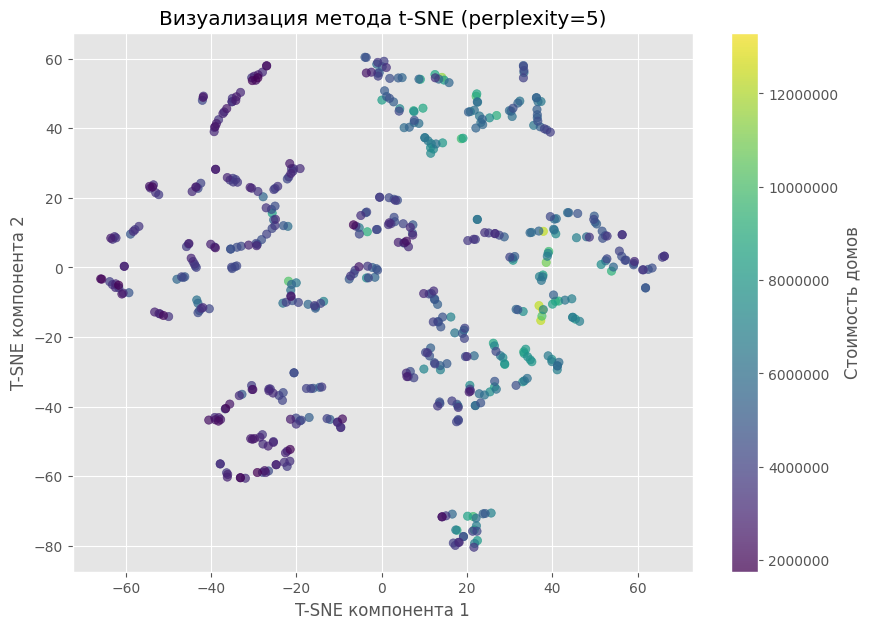

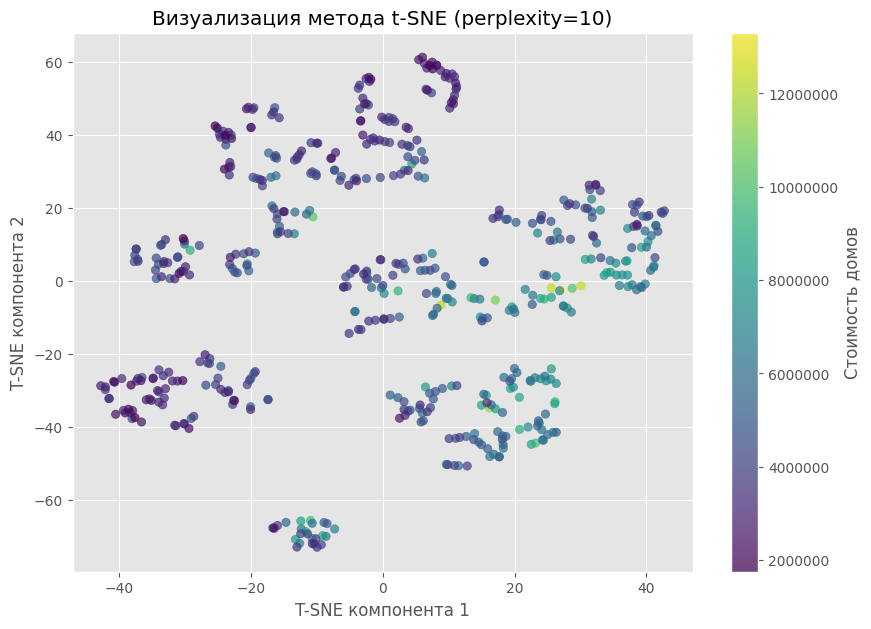

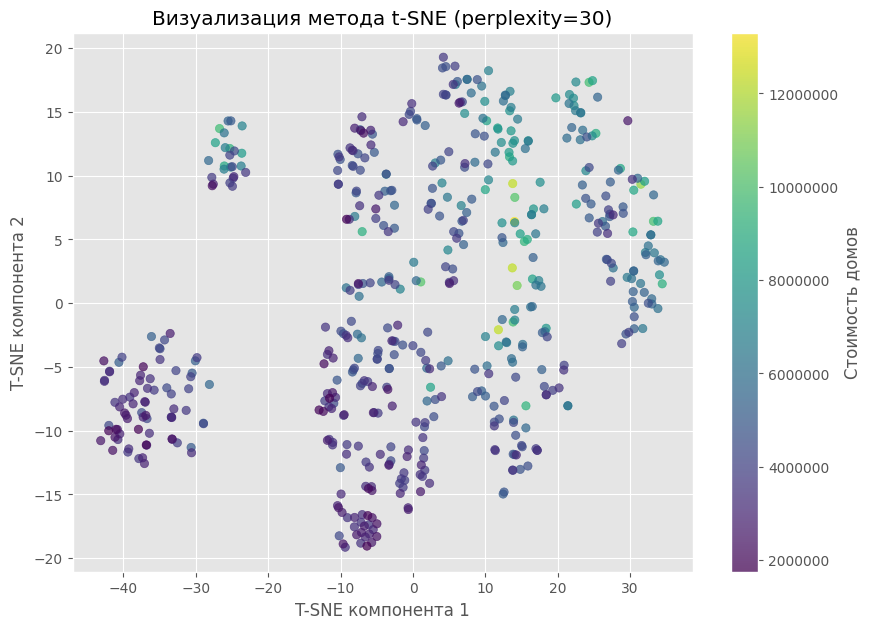

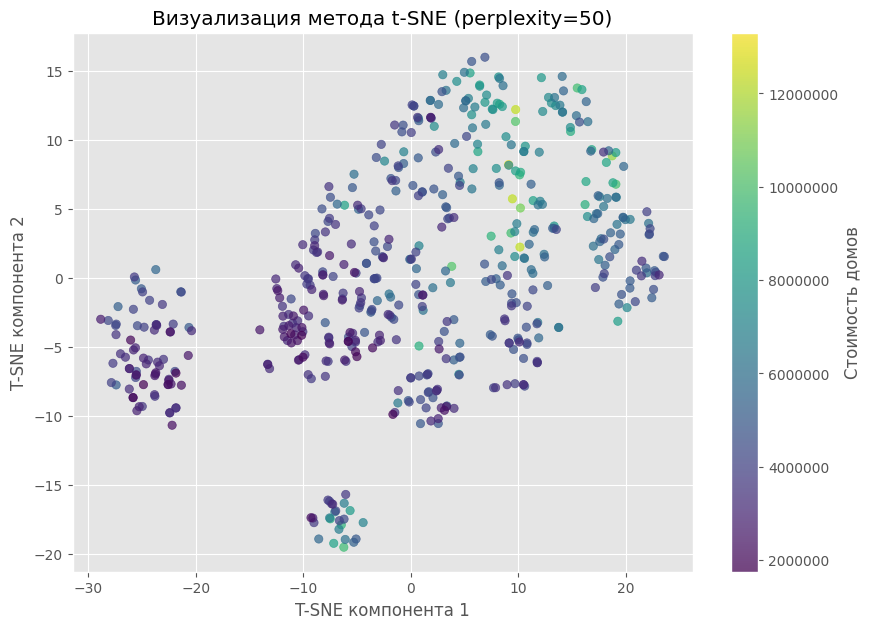

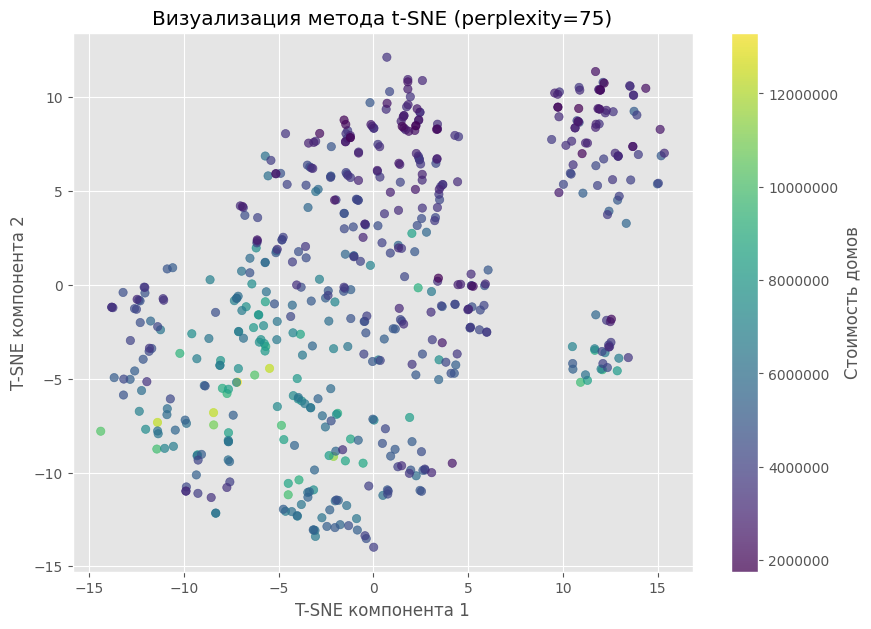

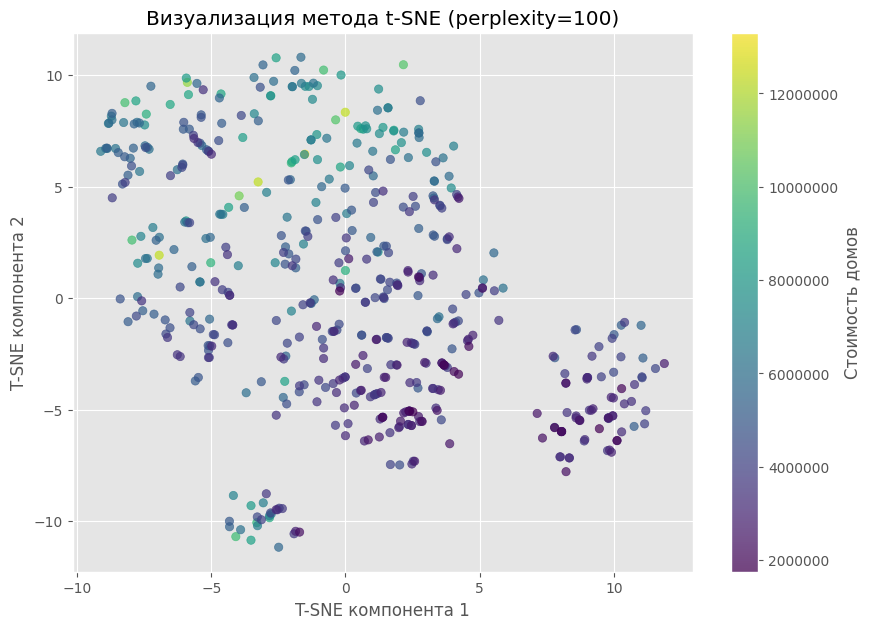

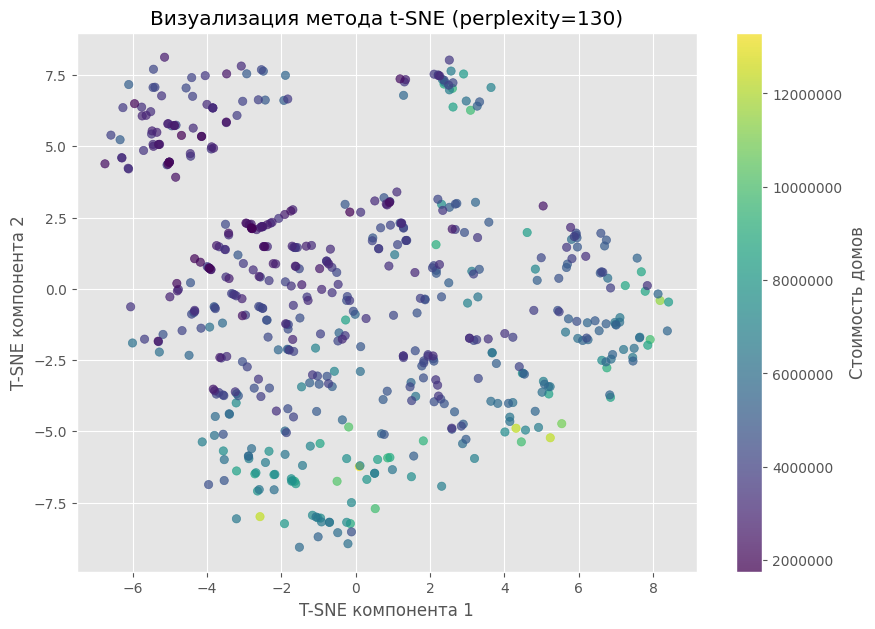

In [ ]:
# Разделение признаков и целевой переменной
X = data.drop('price', axis=1)
y = data['price']

# Перебор значений perplexity
perplexity_values = [5, 10, 30, 50, 75, 100, 130]
for perplexity in perplexity_values:
    visualize_tsne(X.values, y.values, perplexity=perplexity, target_label='Стоимость домов')

In [ ]:
data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [ ]:
data.corr() # корреляционная матрица (по умолчанию по Пирсону)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,-0.304721
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,-0.171445
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,-0.123244
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,-0.143559
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.104672
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,-0.156726
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,-0.118328
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,-0.112831
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,-0.031628
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.150477


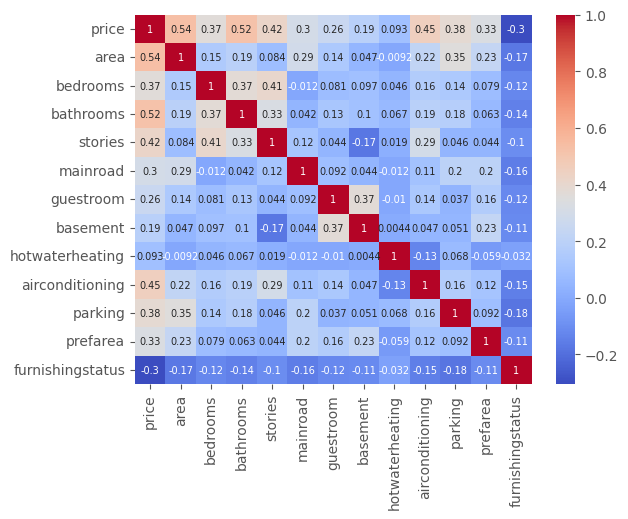

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 7})

plt.show()

Из построения корреляционной матрицы видим, что основное влияние на целевую переменную оказывают 3 признака: area, bathrooms, airconditioning. Попробуем использовать именно эти 3 признака для построения модели линейной регрессии.

# Model Train and Predict


### Обучим модель линейной регрессии на 3-ёх признаках

In [ ]:
features = data[['area', 'bathrooms', 'airconditioning']]

target = data['price']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

norm_features = scaler.fit_transform(features)
norm_features

array([[ 1.04672629,  1.42181174,  1.4726183 ],
       [ 1.75700953,  5.40580863,  1.4726183 ],
       [ 2.21823241,  1.42181174, -0.67906259],
       ...,
       [-0.70592066, -0.57018671, -0.67906259],
       [-1.03338891, -0.57018671, -0.67906259],
       [-0.5998394 , -0.57018671, -0.67906259]])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(norm_features, target, test_size=0.2, random_state=42)

In [ ]:
lm1 = LinearRegression()
lm1

LinearRegression()

In [ ]:
lm1.fit(X_train1,y_train1)

LinearRegression()

In [ ]:
w=lm1.coef_
b=lm1.intercept_
w, b

(array([675581.21470905, 721444.16178804, 537141.58679566]), 4743953.60218976)

In [ ]:
pred1 = lm1.predict(X_test1)
print (pred1[0:5])
print (target[0:5])

[5638485.09518942 6981198.49195599 3621805.50713056 5076692.569128
 3596878.02596815]
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


### Попробуем обучить модель линейной регрессии на всех признаках

In [ ]:
features = data[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus']]

target = data['price']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

norm_features = scaler.fit_transform(features)
norm_features

array([[ 1.04672629,  1.40341936,  1.42181174, ...,  1.51769249,
         1.80494113, -1.40628573],
       [ 1.75700953,  1.40341936,  5.40580863, ...,  2.67940935,
        -0.55403469, -1.40628573],
       [ 2.21823241,  0.04727831,  1.42181174, ...,  1.51769249,
         1.80494113, -0.09166185],
       ...,
       [-0.70592066, -1.30886273, -0.57018671, ..., -0.80574124,
        -0.55403469,  1.22296203],
       [-1.03338891,  0.04727831, -0.57018671, ..., -0.80574124,
        -0.55403469, -1.40628573],
       [-0.5998394 ,  0.04727831, -0.57018671, ..., -0.80574124,
        -0.55403469,  1.22296203]])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(norm_features, target, test_size=0.2, random_state=42)

In [ ]:
lm2 = LinearRegression()
lm2

LinearRegression()

In [ ]:
lm2.fit(X_train2,y_train2)

LinearRegression()

In [ ]:
w=lm2.coef_
b=lm2.intercept_
w, b

(array([ 511355.31486431,   57939.76418471,  550762.10873532,
         352072.08634443,  127770.25363585,   89178.0079421 ,
         187581.88438844,  143909.24149324,  365086.93393877,
         194330.06533066,  267023.36435044, -160043.58443798]),
 4738612.162870701)

In [ ]:
pred2 = lm2.predict(X_test2)
print (pred2[0:5])
print (target[0:5])

[5203691.70963177 7257004.02115475 3062828.59668172 4559591.65374424
 3332932.30559783]
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


### Попробуем обучить модель линейной регрессии на всех признаках, используя автоматический подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, 1, 2, -1],
    'positive': [True, False],
}

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

lm3 = grid_search.best_estimator_

print(grid_search.best_params_)

lm3.fit(X_train2, y_train2)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


LinearRegression()

In [ ]:
w=lm3.coef_
b=lm3.intercept_
w, b

(array([ 511355.31486431,   57939.76418471,  550762.10873532,
         352072.08634443,  127770.25363585,   89178.0079421 ,
         187581.88438844,  143909.24149324,  365086.93393877,
         194330.06533066,  267023.36435044, -160043.58443798]),
 4738612.162870701)

In [ ]:
pred3 = lm3.predict(X_test2)
print (pred3[0:5])
print (target[0:5])

[5203691.70963177 7257004.02115475 3062828.59668172 4559591.65374424
 3332932.30559783]
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


### Регуляризация Лассо - обучение модели на всех признаках с использованием автоматического подбора гиперпараметров

In [ ]:
from sklearn import linear_model

In [ ]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'max_iter': [100, 200, 300, 500, 1000],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
}

grid_search = GridSearchCV(linear_model.Lasso(), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

lm4 = grid_search.best_estimator_

print(grid_search.best_params_)

lm4.fit(X_train2, y_train2)

{'alpha': 1000, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.001}


Lasso(alpha=1000, max_iter=100, tol=0.001)

In [ ]:
w=lm4.coef_
b=lm4.intercept_
w, b

(array([ 511423.22281925,   57929.81296146,  550485.31862873,
         351433.60138526,  127321.40468907,   88927.72964169,
         186885.63446025,  142922.52562964,  364574.70342844,
         193759.83971065,  266373.51667484, -159630.07301285]),
 4738605.177491732)

In [ ]:
pred4 = lm4.predict(X_test2)
print (pred4[0:5])
print (target[0:5])

[5204659.50746265 7254378.1688699  3065342.67631004 4560283.46110154
 3334886.77231265]
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


### Гребневая регуляризация - обучение модели на всех признаках с использованием автоматического подбора гиперпараметров

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'max_iter': [100, 200, 300, 500, 1000],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
}

grid_search = GridSearchCV(Ridge(), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

lm5 = grid_search.best_estimator_

print(grid_search.best_params_)

lm5.fit(X_train2, y_train2)

{'alpha': 10, 'fit_intercept': True, 'max_iter': 100, 'tol': 1e-07}


Ridge(alpha=10, max_iter=100, tol=1e-07)

In [ ]:
w=lm5.coef_
b=lm5.intercept_
w, b

(array([ 501916.38298347,   66472.65522737,  538821.47266734,
         344580.80738951,  130106.42474356,   92522.09762403,
         182455.37747797,  140744.96084172,  361243.24016936,
         195415.85186196,  262470.42316789, -160194.06925127]),
 4738095.948395292)

In [ ]:
pred5 = lm5.predict(X_test2)
print (pred5[0:5])
print (target[0:5])

[5184963.68495913 7213024.14302676 3077871.96039892 4565113.6169642
 3360093.5801345 ]
0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64


# Model Evaluation

## Модель линейной регрессии №1 (обучение на 3-ёх признаках)

In [ ]:
print('R^2, коэффициент детерминации = ', lm1.score(X_train1, y_train1))
print('Средняя квадратическая ошибка (MSE) = ', mean_squared_error(y_test1, pred1))
print('Средняя абсолютная ошибка (MAE) = ', mean_absolute_error(y_test1, pred1))
print('Средний процент отклонения  (MAPE) = ',mean_absolute_percentage_error(y_test1, pred1))
rmse = np.sqrt(mean_squared_error(y_test1, pred1))
print("Root Mean Squared Error:", rmse)

R^2, коэффициент детерминации =  0.5592891823562185
Средняя квадратическая ошибка (MSE) =  2539887537221.1387
Средняя абсолютная ошибка (MAE) =  1228450.9803546113
Средний процент отклонения  (MAPE) =  0.2772547515577522
Root Mean Squared Error: 1593702.4619486344


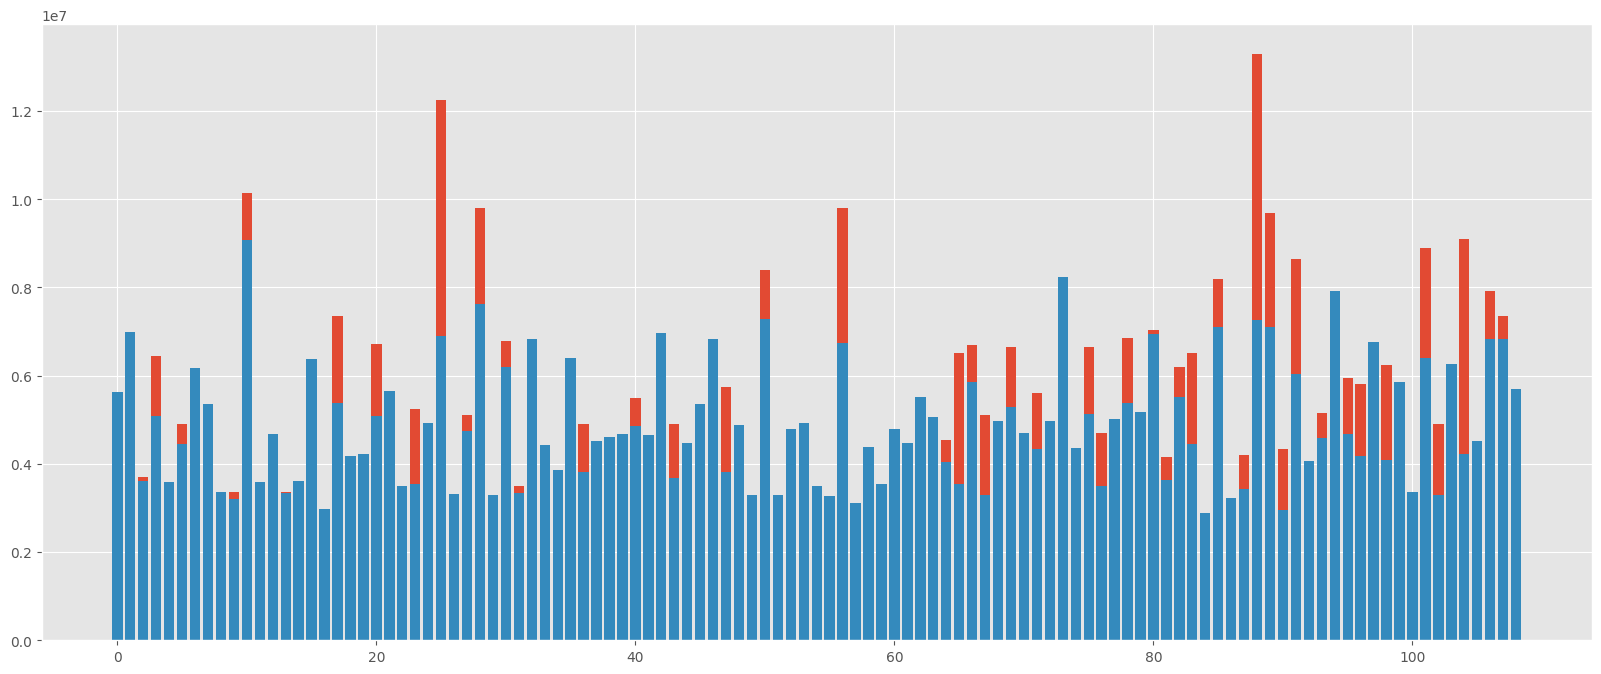

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(list(range(len(X_test1))), y_test1)
plt.bar(list(range(len(X_test1))), pred1)
plt.show()

## Модель линейной регрессии №2 (обучение на всех признаках)

In [ ]:
print('R^2, коэффициент детерминации = ', lm2.score(X_train2, y_train2))
print('Средняя квадратическая ошибка (MSE) = ', mean_squared_error(y_test2, pred2))
print('Средняя абсолютная ошибка (MAE) = ', mean_absolute_error(y_test2, pred2))
print('Средний процент отклонения  (MAPE) = ',mean_absolute_percentage_error(y_test2, pred2))
rmse = np.sqrt(mean_squared_error(y_test2, pred2))
print("Root Mean Squared Error:", rmse)

R^2, коэффициент детерминации =  0.6854429472843788
Средняя квадратическая ошибка (MSE) =  1771751116594.04
Средняя абсолютная ошибка (MAE) =  979679.6912959907
Средний процент отклонения  (MAPE) =  0.2130706787592853
Root Mean Squared Error: 1331071.4167895124


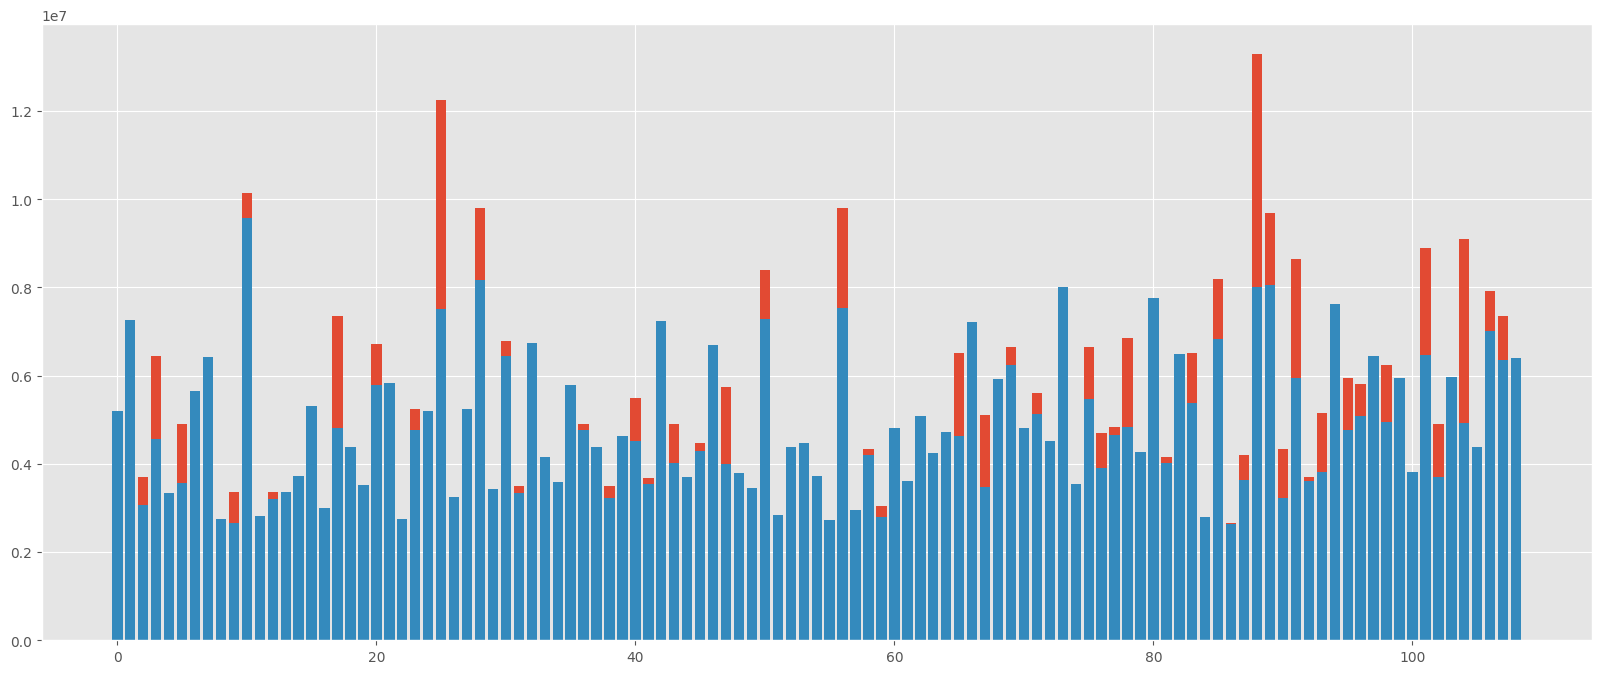

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(list(range(len(X_test2))), y_test2)
plt.bar(list(range(len(X_test2))), pred2)
plt.show()

## Обучение на всех признаках значительно повысило точность предсказаний модели

## Модель линейной регрессии №3 - обучение модели на всех признаках с использованием автоматического подбора гиперпараметров

In [ ]:
print('R^2, коэффициент детерминации = ', lm3.score(X_train2, y_train2))
print('Средняя квадратическая ошибка (MSE) = ', mean_squared_error(y_test2, pred3))
print('Средняя абсолютная ошибка (MAE) = ', mean_absolute_error(y_test2, pred3))
print('Средний процент отклонения  (MAPE) = ',mean_absolute_percentage_error(y_test2, pred3))
rmse = np.sqrt(mean_squared_error(y_test2, pred3))
print("Root Mean Squared Error:", rmse)

R^2, коэффициент детерминации =  0.6854429472843788
Средняя квадратическая ошибка (MSE) =  1771751116594.04
Средняя абсолютная ошибка (MAE) =  979679.6912959907
Средний процент отклонения  (MAPE) =  0.2130706787592853
Root Mean Squared Error: 1331071.4167895124


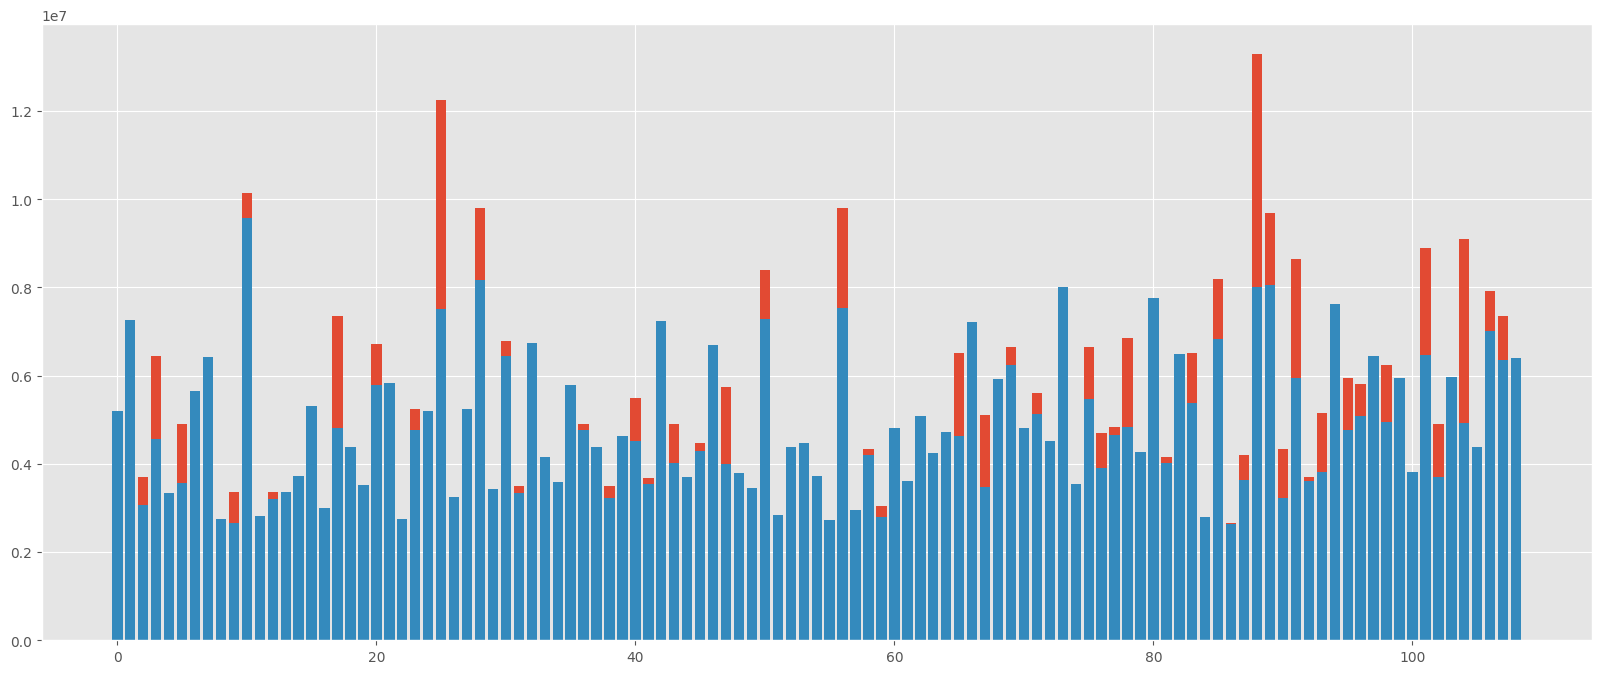

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(list(range(len(X_test2))), y_test2)
plt.bar(list(range(len(X_test2))), pred3)
plt.show()

### Подбор гиперпараметров для модели линейной регрессии не улучшил точность её предсказаний (точность осталась прежней)

## Модель №4 Регуляризация Лассо - обучение модели на всех признаках с использованием автоматического подбора гиперпараметров

In [ ]:
print('R^2, коэффициент детерминации = ', lm4.score(X_train2, y_train2))
print('Средняя квадратическая ошибка (MSE) = ', mean_squared_error(y_test2, pred4))
print('Средняя абсолютная ошибка (MAE) = ', mean_absolute_error(y_test2, pred4))
print('Средний процент отклонения  (MAPE) = ',mean_absolute_percentage_error(y_test2, pred4))
rmse = np.sqrt(mean_squared_error(y_test2, pred4))
print("Root Mean Squared Error:", rmse)

R^2, коэффициент детерминации =  0.6854412191584548
Средняя квадратическая ошибка (MSE) =  1773440776893.8987
Средняя абсолютная ошибка (MAE) =  979983.1865322976
Средний процент отклонения  (MAPE) =  0.2131653756425304
Root Mean Squared Error: 1331705.9648788462


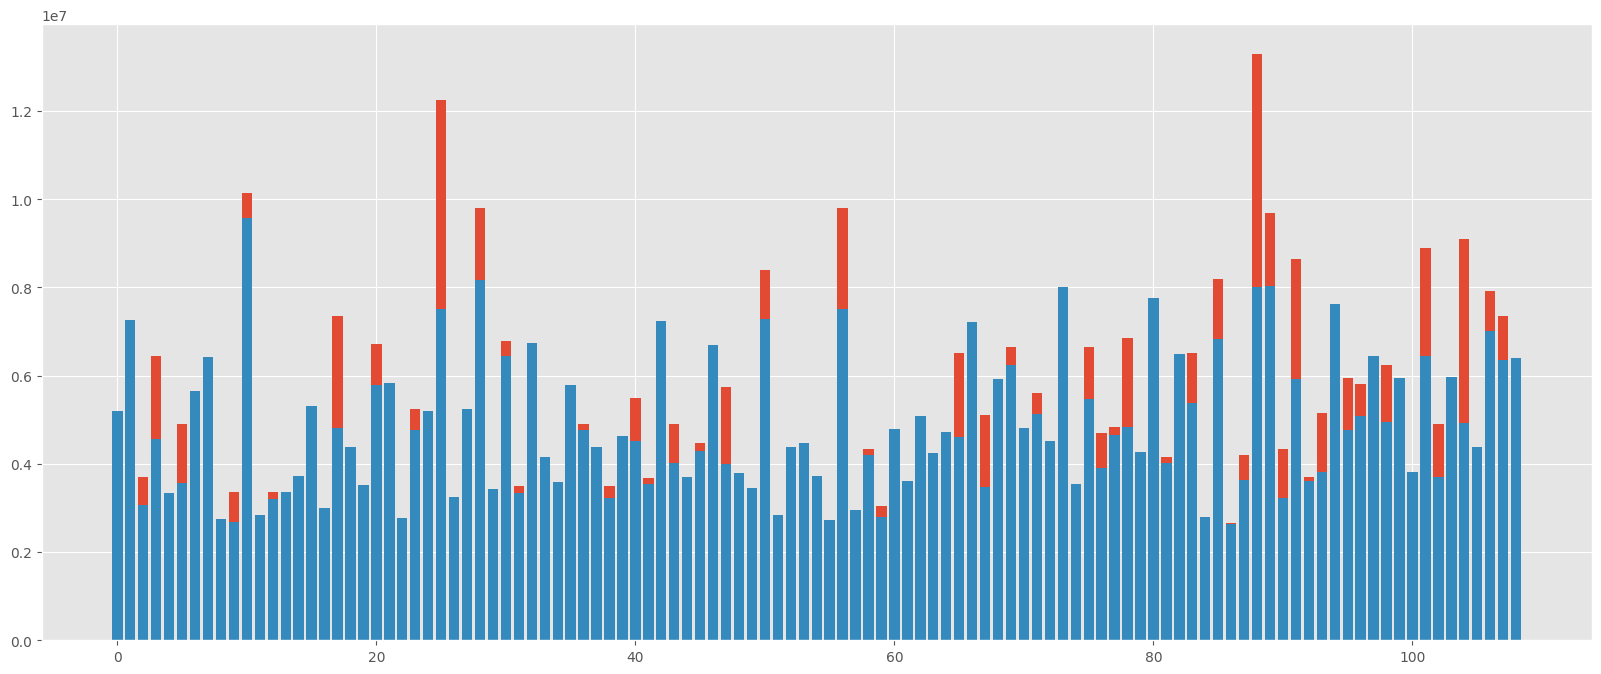

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(list(range(len(X_test2))), y_test2)
plt.bar(list(range(len(X_test2))), pred4)
plt.show()

### Точность предсказаний модели незначительно ухудшилась


## Модель №5 Гребневая регуляризация - обучение модели на всех признаках с использованием автоматического подбора гиперпараметров

In [ ]:
print('R^2, коэффициент детерминации = ', lm5.score(X_train2, y_train2))
print('Средняя квадратическая ошибка (MSE) = ', mean_squared_error(y_test2, pred5))
print('Средняя абсолютная ошибка (MAE) = ', mean_absolute_error(y_test2, pred5))
print('Средний процент отклонения  (MAPE) = ',mean_absolute_percentage_error(y_test2, pred5))
rmse = np.sqrt(mean_squared_error(y_test2, pred5))
print("Root Mean Squared Error:", rmse)

R^2, коэффициент детерминации =  0.6853216986586816
Средняя квадратическая ошибка (MSE) =  1777446008018.0706
Средняя абсолютная ошибка (MAE) =  978267.4372351414
Средний процент отклонения  (MAPE) =  0.21302756905364065
Root Mean Squared Error: 1333208.913868367


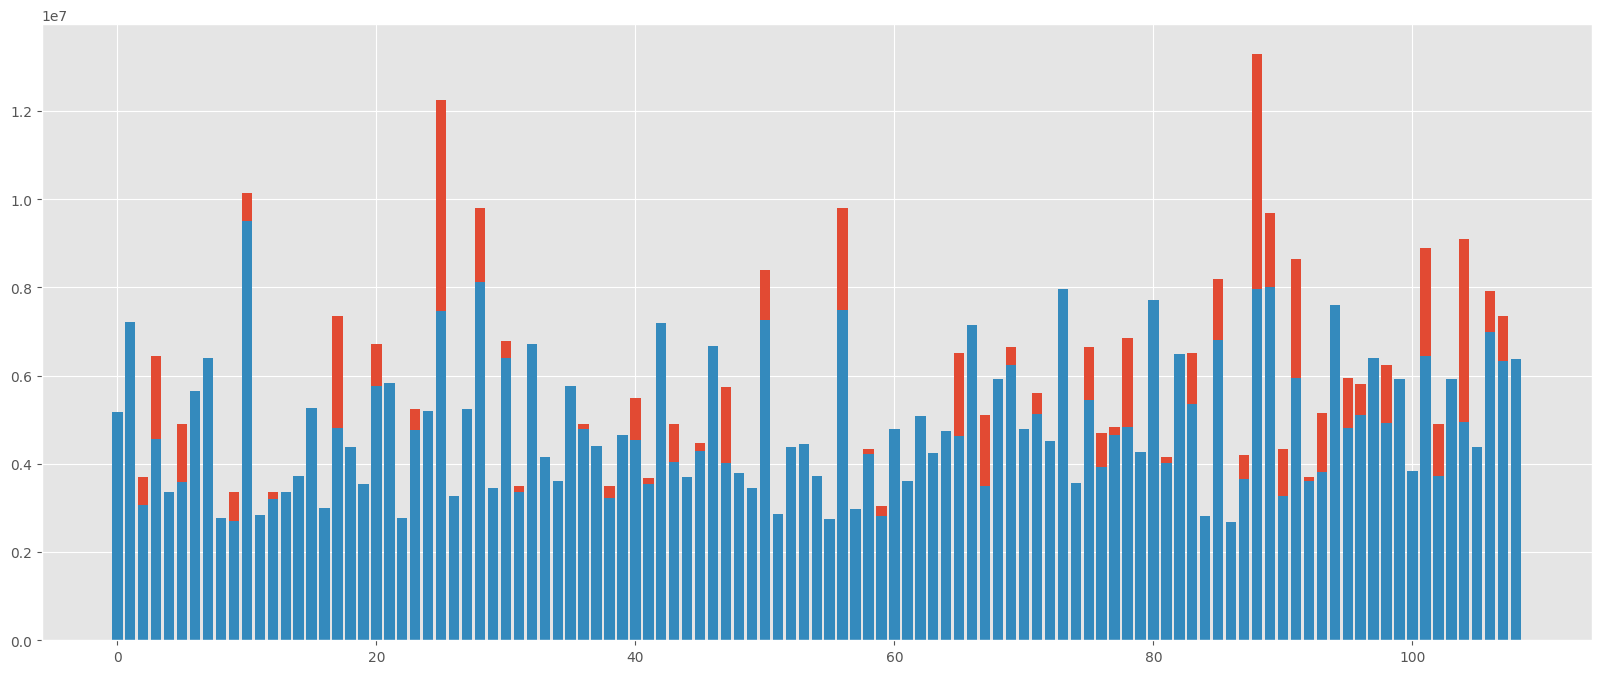

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(list(range(len(X_test2))), y_test2)
plt.bar(list(range(len(X_test2))), pred5)
plt.show()

### Точность предсказаний модели незначительно улучшилась

## Вывод: лучшими моделями по метрикам качества оказались модели линейной регрессии и гребневой регуляризации, обученные на всех признаках с использованием автоматического подбора гиперпараметров

## Регуляризация (штраф за большие веса) даёт эффект только тогда, когда разброс в коэффициентах достаточно значительный (т.е. найденные коэффициенты намного отличаются друг от друга)
